# 라이브러리 불러오기

In [38]:
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

# 랜덤 시드 설정

In [39]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 데이터 불러오기

In [40]:
BASE_PATH = os.path.join("../../..", "data")

train_data = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
test_data = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))
sample_submission = pd.read_csv(os.path.join(BASE_PATH, 'sample_submission.csv'))

interest_data = pd.read_csv(os.path.join(BASE_PATH, 'interestRate.csv'))

# 데이터 EDA 수행하기

In [41]:
print("train, test_data, sample_submission info : ", "\n", train_data.info(), test_data.info(), sample_submission.info(), interest_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1801228 entries, 0 to 1801227
Data columns (total 11 columns):
 #   Column               Dtype  
---  ------               -----  
 0   index                int64  
 1   area_m2              float64
 2   contract_year_month  int64  
 3   contract_day         int64  
 4   contract_type        int64  
 5   floor                int64  
 6   built_year           int64  
 7   latitude             float64
 8   longitude            float64
 9   age                  int64  
 10  deposit              float64
dtypes: float64(4), int64(7)
memory usage: 151.2 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150172 entries, 0 to 150171
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   index                150172 non-null  int64  
 1   area_m2              150172 non-null  float64
 2   contract_year_month  150172 non-null  int64  
 3   contract_day         1

In [42]:
# 월별 거래량 확인
monthly_transaction = train_data.groupby('contract_year_month').size().reset_index(name='monthly_transaction')

# 월별 평균 deposit 계산
monthly_avg_deposit = train_data.groupby('contract_year_month')['deposit'].mean().reset_index(name='avg_deposit')

# Merge with interest_data
deposit_and_interest_df = pd.merge(monthly_transaction, 
                                   interest_data[['year_month', 'interest_rate']], 
                                   left_on='contract_year_month', 
                                   right_on='year_month', 
                                   how='left')

# Merge with monthly_avg_deposit
deposit_and_interest_df = pd.merge(deposit_and_interest_df, 
                                   monthly_avg_deposit, 
                                   on='contract_year_month', 
                                   how='left')[['year_month', 'monthly_transaction', 'interest_rate', 'avg_deposit']]

# Convert year_month to datetime
deposit_and_interest_df["year_month"] = pd.to_datetime(deposit_and_interest_df["year_month"], format='%Y%m')

# Display the first few rows
deposit_and_interest_df.head()

,year_month,monthly_transaction,interest_rate,avg_deposit
0,2019-04-01,22136,1.85,30447.425958
1,2019-05-01,22860,1.85,31132.991601
2,2019-06-01,23533,1.78,31111.287554
3,2019-07-01,25951,1.68,31621.427691
4,2019-08-01,25862,1.52,31712.702769


In [43]:
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False 

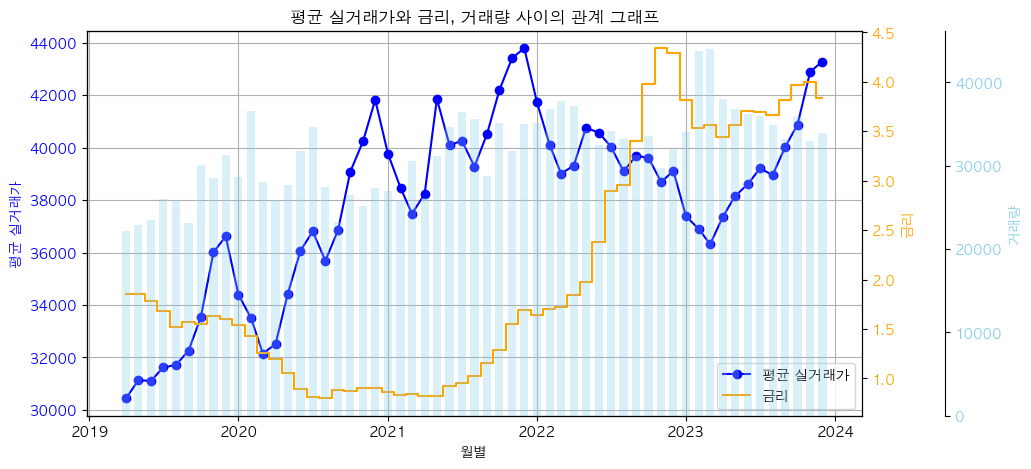

In [9]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# 첫 번째 y축 (평균 실거래가)
ax1.set_xlabel('월별')
ax1.set_ylabel('평균 실거래가', color='b')
line1 = ax1.plot(deposit_and_interest_df['year_month'], deposit_and_interest_df['avg_deposit'], label='평균 실거래가', marker='o', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# 두 번째 y축 (금리)
ax2 = ax1.twinx()
ax2.set_ylabel('금리', color='orange')
line2 = ax2.step(deposit_and_interest_df['year_month'], deposit_and_interest_df['interest_rate'], label='금리', where='mid', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 세 번째 y축 (거래량)
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # 세 번째 축을 조금 오른쪽으로 이동
ax3.set_ylabel('거래량', color='skyblue')
line3 = ax3.bar(deposit_and_interest_df['year_month'], deposit_and_interest_df['monthly_transaction'], label='거래량', color='skyblue', alpha=0.3, width=20)
ax3.tick_params(axis='y', labelcolor='skyblue')

# 제목과 범례
plt.title('평균 실거래가와 금리, 거래량 사이의 관계 그래프')

# 첫 번째 y축의 그리드 설정
ax1.grid(True)

# 범례 추가
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='lower right')

plt.show()

In [44]:
merge_data = train_data.copy()
merge_data = merge_data.merge(interest_data, how='left', left_on="contract_year_month", right_on='year_month').drop(columns=["year_month", "index"])

# Deposit과 InterestRate의 상관관계

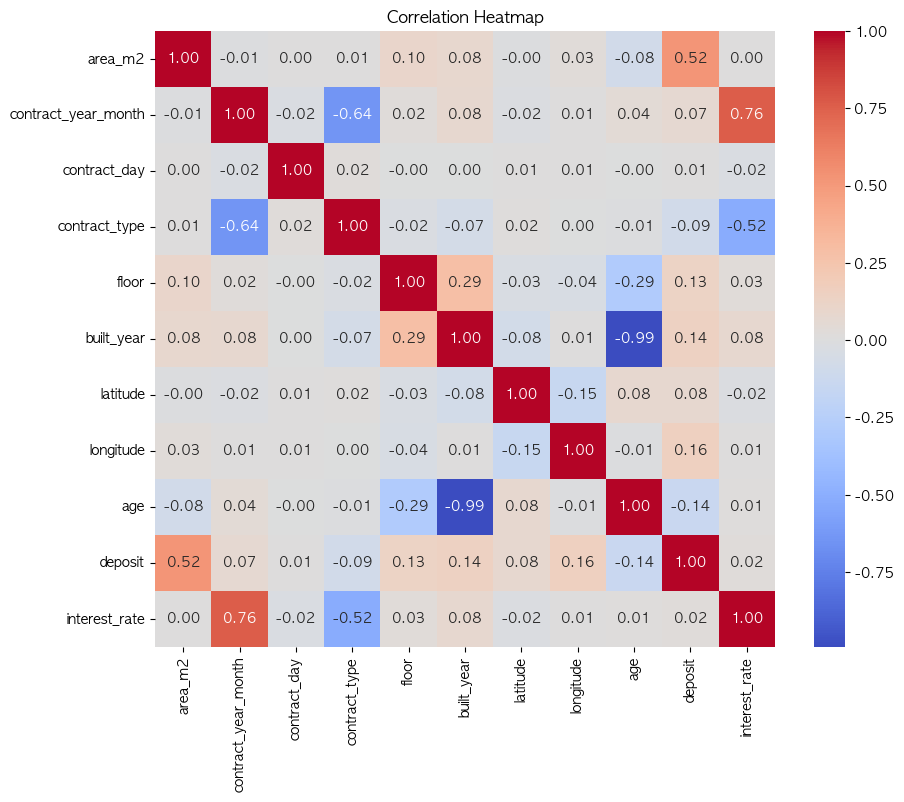

In [28]:
cor_m = merge_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(cor_m, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

- 일반적으로 대출과 금리 사이의 연관성은 반비례 관계에 있다고 생각하기 쉽지만 수치상으로는 **0.02**로 미미하다는 것을 알 수 있음
- 중앙 정부가 금리 변화에 대한 시그널을 밝히는만큼, 그렇다면 혹시 위 그래프에서의 반비례 관계가 어느정도의 시차를 두고 발현되지는 않을까?

In [30]:
merge_data["early6"] = merge_data["interest_rate"].shift(6)
merge_data["early5"] = merge_data["interest_rate"].shift(5)
merge_data["early4"] = merge_data["interest_rate"].shift(4)
merge_data["early3"] = merge_data["interest_rate"].shift(3)
merge_data["early2"] = merge_data["interest_rate"].shift(2)
merge_data["early1"] = merge_data["interest_rate"].shift(1)
merge_data["late1"] = merge_data["interest_rate"].shift(-1)
merge_data["late2"] = merge_data["interest_rate"].shift(-2)
merge_data["late3"] = merge_data["interest_rate"].shift(-3)
merge_data["late4"] = merge_data["interest_rate"].shift(-4)
merge_data["late5"] = merge_data["interest_rate"].shift(-5)
merge_data["late6"] = merge_data["interest_rate"].shift(-6)
merge_data.head()

,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit,...,early4,early3,early2,early1,late1,late2,late3,late4,late5,late6
0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,17000.0,...,NaN,NaN,NaN,NaN,1.26,1.26,1.68,1.85,1.85,1.85
1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,23000.0,...,NaN,NaN,NaN,1.78,1.26,1.68,1.85,1.85,1.85,1.85
2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,23000.0,...,NaN,NaN,1.78,1.26,1.68,1.85,1.85,1.85,1.85,1.85
3,59.3400,201907,15,2,1,1986,36.964647,127.055847,33,5000.0,...,NaN,1.78,1.26,1.26,1.85,1.85,1.85,1.85,1.85,1.85
4,59.8100,201904,12,2,6,1995,36.972390,127.084514,24,1800.0,...,1.78,1.26,1.26,1.68,1.85,1.85,1.85,1.85,1.85,1.78


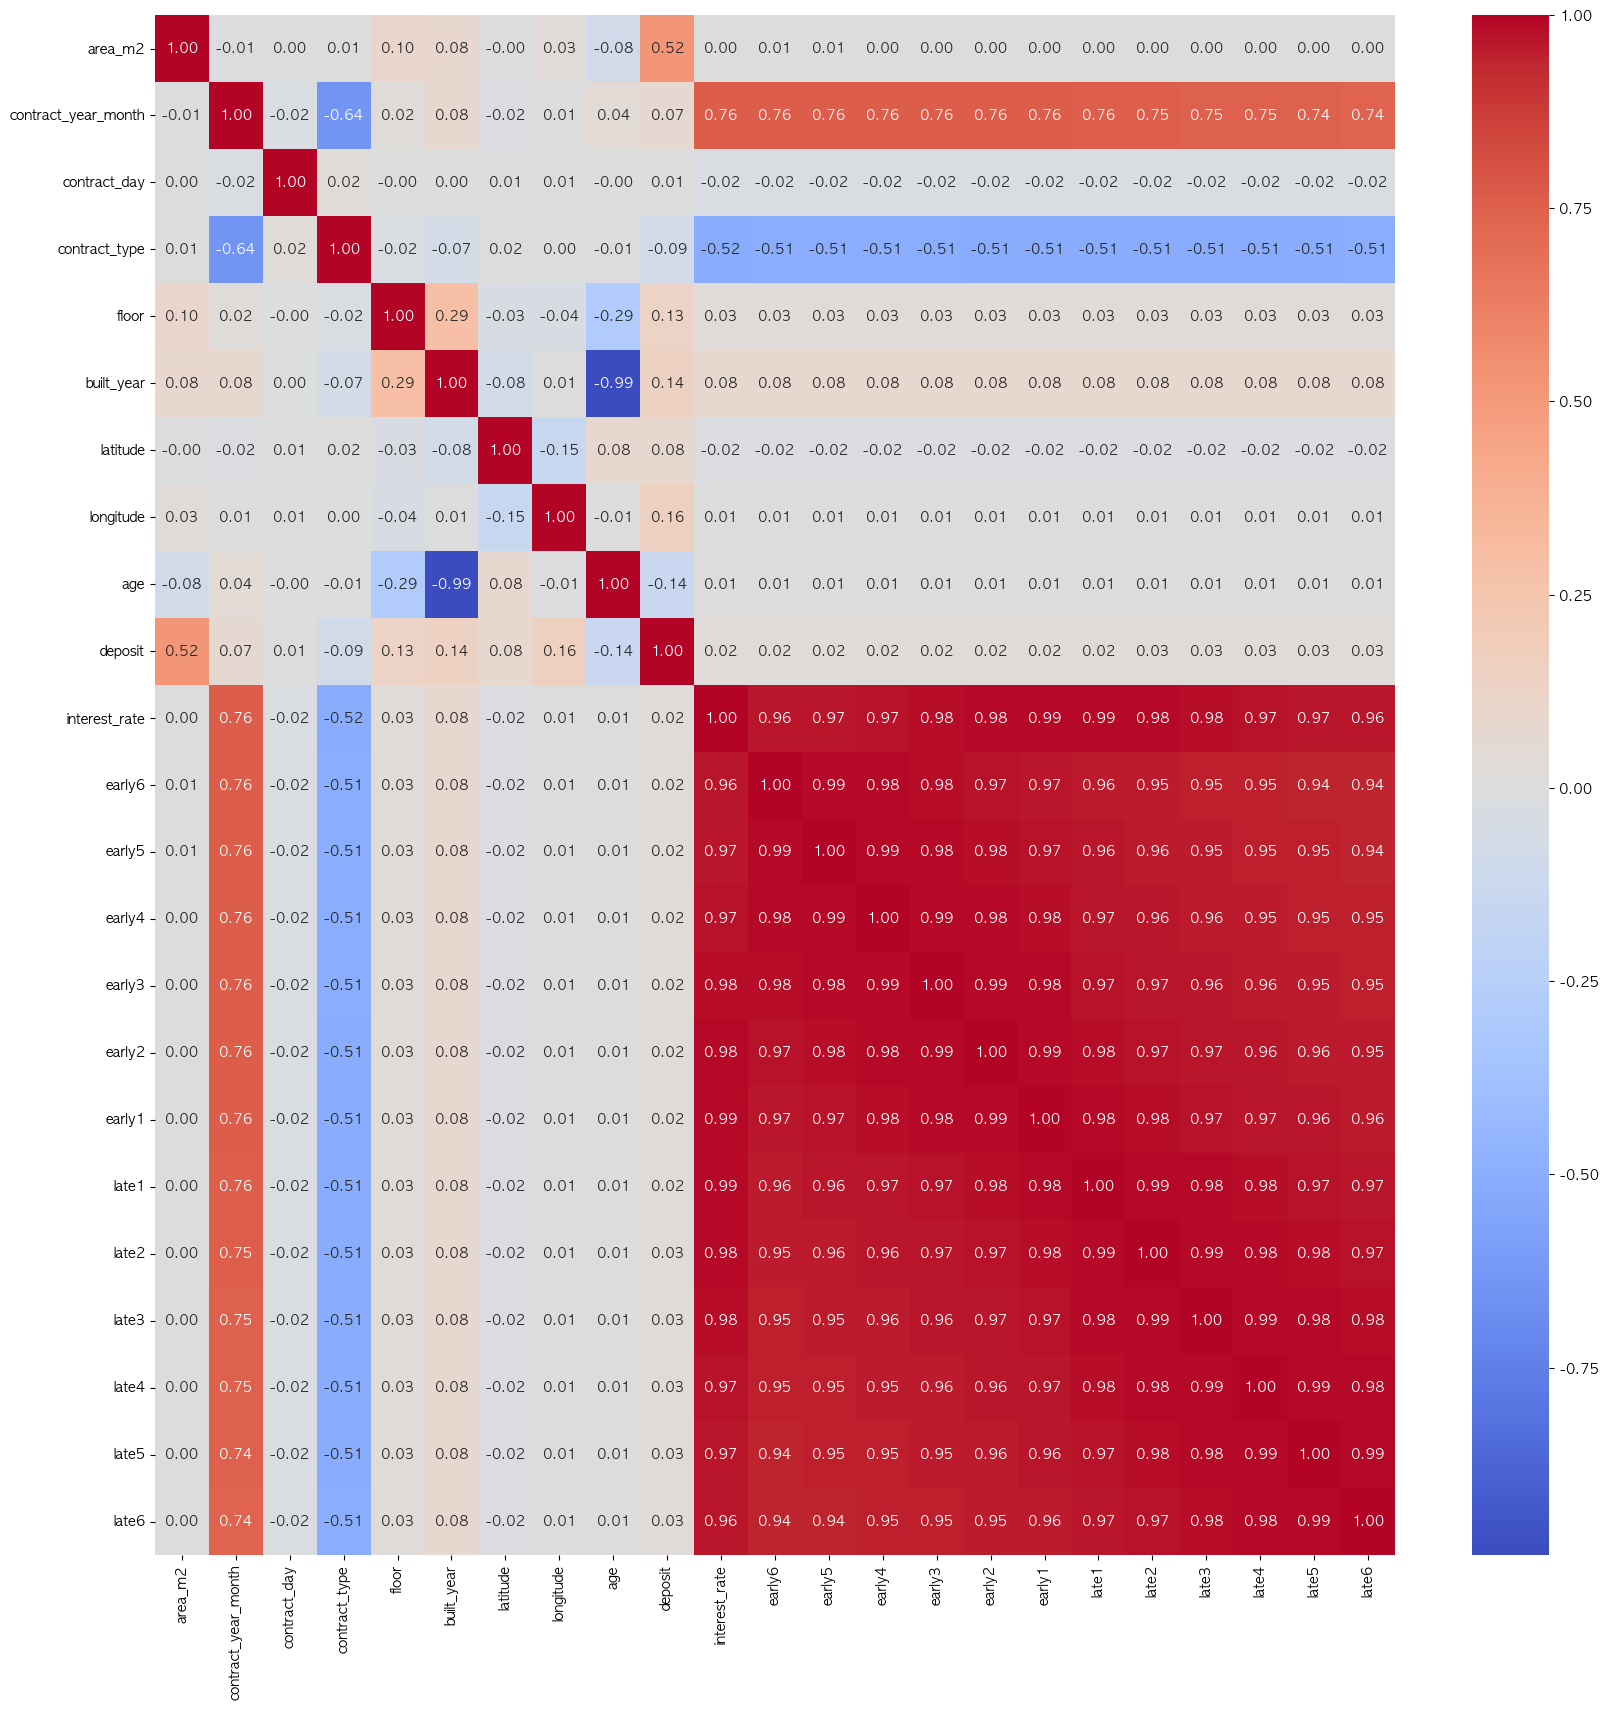

In [35]:
cor_m = merge_data.corr()

plt.figure(figsize=(20,20))
sns.heatmap(cor_m, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

In [8]:
cor_m = deposit_and_interest_df[['avg_deposit', 'interest_rate']].corr()
cor_m

,avg_deposit,interest_rate
avg_deposit,1.000000,0.206548
interest_rate,0.206548,1.000000


- 육안상으로는 실거래가와 금리의 관계가 반비례 관계인 것처럼 보이나, 실제 상관관계 확인시 0.21이라는 애매한 수치임을 볼 수 있음.
- 평균 실거래가의 차이로 비교하면 금리 변동에 따른 실거래가의 변화를 확인할 수 있을 것 같음.

In [9]:
deposit_and_interest_df["deposit_diff"] = deposit_and_interest_df["avg_deposit"].diff()
deposit_and_interest_df["deposit_diff"] = deposit_and_interest_df["deposit_diff"].fillna(0)

cor_m2 = deposit_and_interest_df.drop(columns=['year_month']).corr()
cor_m2

,monthly_transaction,interest_rate,avg_deposit,deposit_diff
monthly_transaction,1.000000,0.469879,0.466751,-0.167065
interest_rate,0.469879,1.000000,0.206548,-0.049724
avg_deposit,0.466751,0.206548,1.000000,0.131533
deposit_diff,-0.167065,-0.049724,0.131533,1.000000


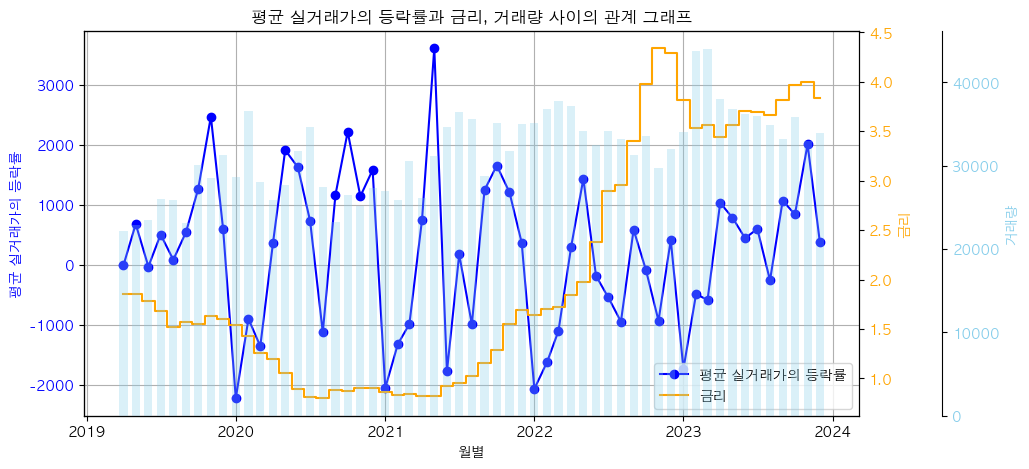

In [82]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# 첫 번째 y축 (평균 실거래가의 등락률)
ax1.set_xlabel('월별')
ax1.set_ylabel('평균 실거래가의 등락률', color='b')
line1 = ax1.plot(deposit_and_interest_df['year_month'], deposit_and_interest_df['deposit_diff'], label='평균 실거래가의 등락률', marker='o', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# 두 번째 y축 (금리)
ax2 = ax1.twinx()
ax2.set_ylabel('금리', color='orange')
line2 = ax2.step(deposit_and_interest_df['year_month'], deposit_and_interest_df['interest_rate'], label='금리', where='mid', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 세 번째 y축 (거래량)
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # 세 번째 축을 조금 오른쪽으로 이동
ax3.set_ylabel('거래량', color='skyblue')
line3 = ax3.bar(deposit_and_interest_df['year_month'], deposit_and_interest_df['monthly_transaction'], label='거래량', color='skyblue', alpha=0.3, width=20)
ax3.tick_params(axis='y', labelcolor='skyblue')

# 제목과 범례
plt.title('평균 실거래가의 등락률과 금리, 거래량 사이의 관계 그래프')

# 첫 번째 y축의 그리드 설정
ax1.grid(True)

# 범례 추가
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='lower right')

plt.show()

In [84]:
cor_m = deposit_and_interest_df[['deposit_diff', 'interest_rate']].corr()
cor_m

,deposit_diff,interest_rate
deposit_diff,1.000000,-0.049724
interest_rate,-0.049724,1.000000


In [11]:
train_data.groupby(['latitude', 'longitude']).size().reset_index(name='count')

,latitude,longitude,count
0,36.917910,126.908029,17
1,36.957089,127.047449,73
2,36.959894,127.045371,3
3,36.960034,127.059939,103
4,36.960936,127.054219,5
...,...,...,...
18486,38.096380,127.076702,4
18487,38.101890,127.079581,31
18488,38.104768,127.079949,88
18489,38.106033,127.077652,19


In [12]:
train_data.groupby(['contract_year_month', 'latitude', 'longitude']).size().reset_index(name='count')

,contract_year_month,latitude,longitude,count
0,201904,36.960034,127.059939,5
1,201904,36.961599,126.918827,1
2,201904,36.961815,127.058042,1
3,201904,36.961829,127.055295,1
4,201904,36.963650,127.060117,1
...,...,...,...,...
431508,202312,37.941002,127.230788,3
431509,202312,38.020074,127.069846,1
431510,202312,38.022738,127.074334,3
431511,202312,38.101890,127.079581,2


In [18]:
# 갯수 count
grouped_count = train_data.groupby(['contract_year_month', 'latitude', 'longitude']).size().reset_index(name='count')
total_count = train_data.groupby(['latitude', 'longitude']).size().reset_index(name='total_count')

# 월별 최고, 최저, 평균 실거래가 
grouped_prices = train_data.groupby(['contract_year_month', 'latitude', 'longitude'])['deposit'].agg(['max', 'min', 'mean']).reset_index()

# 데이터프레임 병합
new_df = pd.merge(grouped_count, grouped_prices, on=['contract_year_month', 'latitude', 'longitude'])
new_df = pd.merge(new_df, total_count, on=['latitude', 'longitude']).sort_values(by="total_count", ascending=False).sort_values(by="contract_year_month")

# 열 이름 수정
new_df.rename(columns={'max': 'hightst_price', 'min': 'lowest_price', 'mean': 'avg_price'}, inplace=True)

new_df["contract_year_month"] = pd.to_datetime(new_df["contract_year_month"], format='%Y%m')
# 결과 확인
new_df.head()

,contract_year_month,latitude,longitude,count,hightst_price,lowest_price,avg_price,total_count
1884,2019-04-01,37.406105,127.154583,2,30000.0,28000.0,29000.000000,98
3094,2019-04-01,37.498304,126.923080,1,36000.0,36000.0,36000.000000,60
91,2019-04-01,37.003595,127.085282,3,9000.0,8000.0,8333.333333,642
3319,2019-04-01,37.505953,127.114490,1,56000.0,56000.0,56000.000000,237
4373,2019-04-01,37.547464,126.675322,3,20000.0,14000.0,16433.333333,60


In [86]:
new_df.sort_values(by="total_count", ascending=False).head()

,contract_year_month,latitude,longitude,count,hightst_price,lowest_price,avg_price,total_count
165567,2021-02-01,37.654629,127.34043,84,22000.0,14500.0,18267.857143,5108
188461,2021-05-01,37.654629,127.34043,75,36000.0,14500.0,18641.333333,5108
204123,2021-07-01,37.654629,127.34043,53,35000.0,14500.0,19707.547170,5108
258986,2022-02-01,37.654629,127.34043,81,38000.0,14500.0,18118.518519,5108
173216,2021-03-01,37.654629,127.34043,88,33000.0,14500.0,18085.227273,5108


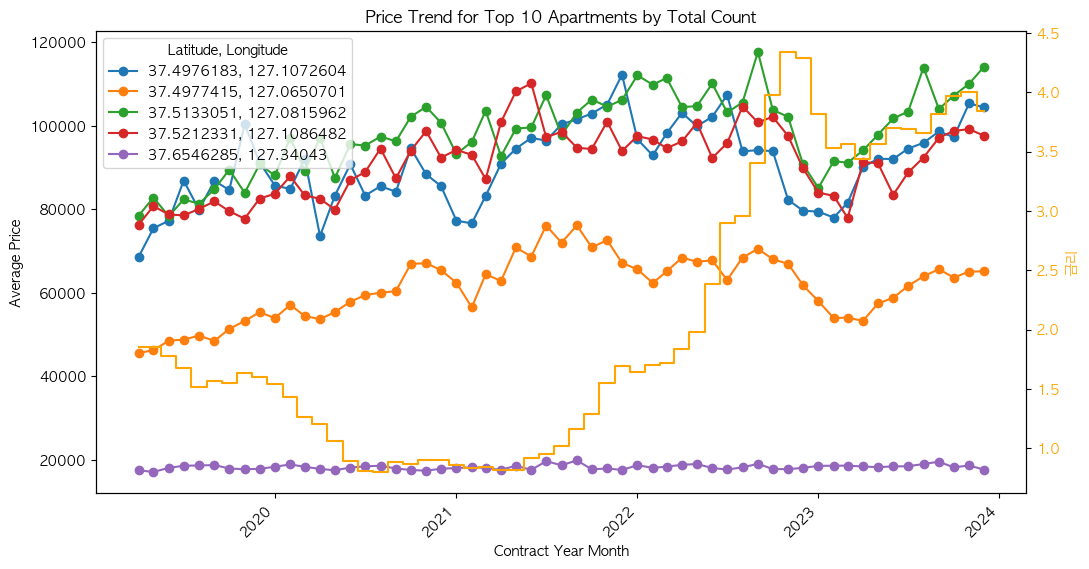

In [87]:
# Extract the top 10 apartments based on total_count
top_10_lat_long = new_df.groupby(['latitude', 'longitude'])['total_count'].max().nlargest(5).reset_index()

# Extract data for the top 10 apartments
top_10_total_count = new_df[new_df[['latitude', 'longitude']].apply(tuple, axis=1).isin(top_10_lat_long[['latitude', 'longitude']].apply(tuple, axis=1))]

# specific_lat_long = new_df[(new_df['latitude'] == top_10_lat_long['latitude']) & 
#                            (new_df['longitude'] == top_10_lat_long['longitude'])]

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Plotting the price trend for each of the top 10 apartments
for lat_long, group in top_10_total_count.groupby(['latitude', 'longitude']):
    ax.plot(group['contract_year_month'], group['avg_price'], marker='o', label=f'{lat_long[0]}, {lat_long[1]}')

# Set labels and title
ax.set_xlabel('Contract Year Month')
ax.set_ylabel('Average Price')
ax.set_title('Price Trend for Top 10 Apartments by Total Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add legend
ax.legend(title='Latitude, Longitude')

ax2 = ax.twinx()
ax2.set_ylabel('금리', color='orange')
ax2.step(deposit_and_interest_df['year_month'], deposit_and_interest_df['interest_rate'], label='금리', where='mid', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Show plot
plt.show()

/var/folders/68/zvjwc4g973dgknpsjc6dy3g00000gn/T/ipykernel_42279/1363745432.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_2_total_count['price_change'] = top_2_total_count.groupby(['latitude', 'longitude'])['avg_price'].pct_change().fillna(0) * 100


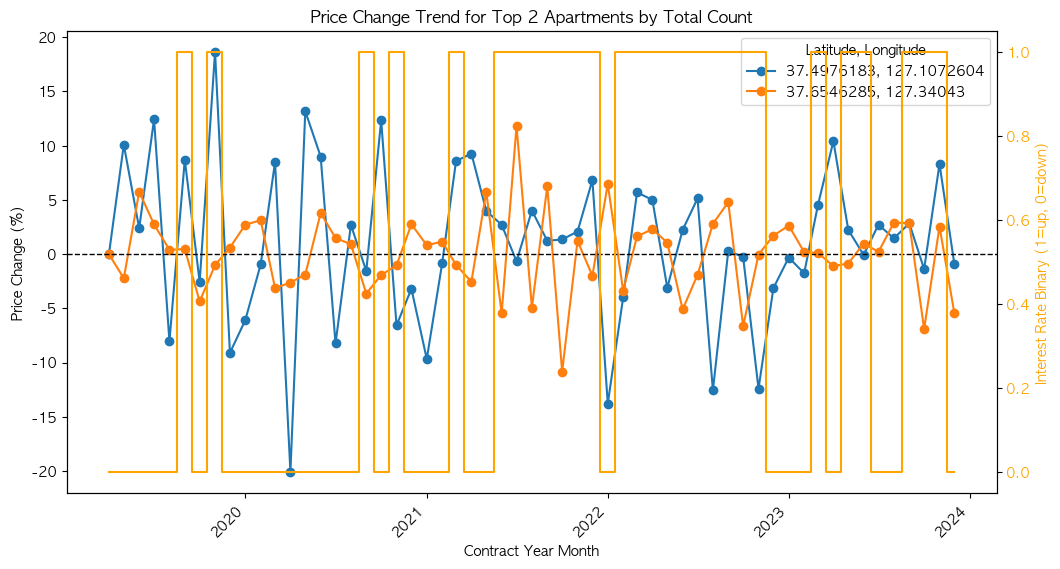

In [69]:
# 두 번째로 높은 total_count 아파트를 기준으로 데이터 추출
top_2_lat_long = new_df.groupby(['latitude', 'longitude'])['total_count'].max().nlargest(2).reset_index()

# top 2 아파트의 데이터만 필터링
top_2_total_count = new_df[new_df[['latitude', 'longitude']].apply(tuple, axis=1).isin(top_2_lat_long[['latitude', 'longitude']].apply(tuple, axis=1))]

# 등락률 계산 (월간 평균 가격 변화율)
top_2_total_count['price_change'] = top_2_total_count.groupby(['latitude', 'longitude'])['avg_price'].pct_change().fillna(0) * 100
# 금리 데이터의 상승/하락 여부 이진화
deposit_and_interest_df['interest_change'] = deposit_and_interest_df['interest_rate'].pct_change().fillna(0)
deposit_and_interest_df['interest_binary'] = (deposit_and_interest_df['interest_change'] > 0).astype(int)  # 상승이면 1, 하락이면 0

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# 각 아파트의 가격 변동 등락률을 플롯
for lat_long, group in top_2_total_count.groupby(['latitude', 'longitude']):
    ax.plot(group['contract_year_month'], group['price_change'], marker='o', label=f'{lat_long[0]}, {lat_long[1]}')

# 축 레이블 및 제목 설정
ax.set_xlabel('Contract Year Month')
ax.set_ylabel('Price Change (%)')
ax.set_title('Price Change Trend for Top 2 Apartments by Total Count')

# x축 라벨 각도 조정
plt.xticks(rotation=45, ha='right')


# 금리 데이터 상승/하락 이진화된 데이터를 시각화
ax2 = ax.twinx()
ax2.set_ylabel('Interest Rate Binary (1=up, 0=down)', color='orange')
ax2.step(deposit_and_interest_df['year_month'], deposit_and_interest_df['interest_binary'], where='mid', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 원점에 수평선 추가 (y=0 기준선)
ax.axhline(0, color='black', linewidth=1, linestyle='--')


# 범례 추가
ax.legend(title='Latitude, Longitude')

# 그래프 출력
plt.show()

Correlation between price change and interest rate category: 0.023722524142547146


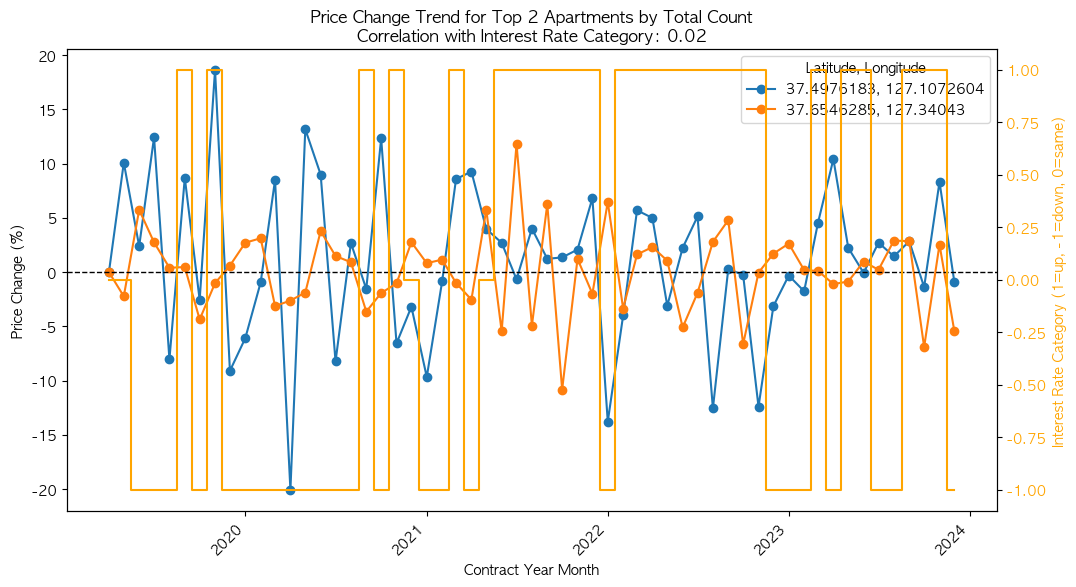

In [70]:
# 금리 데이터의 상승/하락/유지 여부 분류
deposit_and_interest_df['interest_change'] = deposit_and_interest_df['interest_rate'].pct_change().fillna(0)

# 금리 변화를 세 가지 카테고리로 분류
deposit_and_interest_df['interest_category'] = deposit_and_interest_df['interest_change'].apply(
    lambda x: 1 if x > 0 else (-1 if x < 0 else 0)
)

# top_2_total_count와 deposit_and_interest_df를 year_month 기준으로 병합
merged_df = pd.merge(top_2_total_count, deposit_and_interest_df[['year_month', 'interest_category']], left_on='contract_year_month', right_on='year_month', how='inner')

# 상관관계 계산 (가격 변동률과 금리 3분류 데이터)
correlation = merged_df['price_change'].corr(merged_df['interest_category'])
print(f"Correlation between price change and interest rate category: {correlation}")

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# 각 아파트의 가격 변동 등락률을 플롯
for lat_long, group in top_2_total_count.groupby(['latitude', 'longitude']):
    ax.plot(group['contract_year_month'], group['price_change'], marker='o', label=f'{lat_long[0]}, {lat_long[1]}')

# 축 레이블 및 제목 설정
ax.set_xlabel('Contract Year Month')
ax.set_ylabel('Price Change (%)')
ax.set_title(f'Price Change Trend for Top 2 Apartments by Total Count\nCorrelation with Interest Rate Category: {correlation:.2f}')

# x축 라벨 각도 조정
plt.xticks(rotation=45, ha='right')

# 범례 추가
ax.legend(title='Latitude, Longitude')

# 금리 데이터 상승/하락/유지 분류 데이터를 시각화
ax2 = ax.twinx()
ax2.set_ylabel('Interest Rate Category (1=up, -1=down, 0=same)', color='orange')
ax2.step(deposit_and_interest_df['year_month'], deposit_and_interest_df['interest_category'], where='mid', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 원점에 수평선 추가 (y=0 기준선)
ax.axhline(0, color='black', linewidth=1, linestyle='--')

# 그래프 출력
plt.show()

- target을 평당 가격으로
- 평수 기준으로, 일반적으로 방이 몇개 정도 될 것이다를 추정해서. 발생한 거래가 자녀를 위한 것인지, 아니면 노후를 위한 것인지, 교육을 위한 것인지 파악해보는 것도 의미가 있을 것 같고, 이게 금리와의 시너지를 통해 전세가격 예측에 도움을 주지 않을까?
- 1~2인 

In [135]:
new_df['contract_year_month'] = pd.to_datetime(new_df['contract_year_month'], format='%Y%m')
new_df[np.isclose(new_df['latitude'], 36.960034) & np.isclose(new_df['longitude'], 127.059939)]

,contract_year_month,latitude,longitude,count,hightst_price,lowest_price,avg_price
0,2019-04-01,36.960034,127.059939,5,13000.0,12500.0,12900.000000
6601,2019-05-01,36.960034,127.059939,2,14000.0,13000.0,13500.000000
13389,2019-06-01,36.960034,127.059939,1,13000.0,13000.0,13000.000000
27202,2019-08-01,36.960034,127.059939,1,13000.0,13000.0,13000.000000
34193,2019-09-01,36.960034,127.059939,2,12000.0,9000.0,10500.000000
41026,2019-10-01,36.960034,127.059939,1,13000.0,13000.0,13000.000000
48619,2019-11-01,36.960034,127.059939,4,14500.0,13000.0,13625.000000
55801,2019-12-01,36.960034,127.059939,1,13000.0,13000.0,13000.000000
63199,2020-01-01,36.960034,127.059939,3,14000.0,11500.0,12833.333333
70478,2020-02-01,36.960034,127.059939,4,13000.0,12000.0,12250.000000


In [123]:
count_contract_df = train_data.groupby(['latitude', 'longitude']).size().reset_index(name='count').sort_values(by='count', ascending=True)
count_contract_df.describe()

,latitude,longitude,count
count,18491.000000,18491.000000,18491.000000
mean,37.490355,126.957823,97.411065
std,0.148037,0.168177,190.146865
min,36.917910,126.478708,1.000000
25%,37.440464,126.840356,6.000000
50%,37.506791,126.964875,26.000000
75%,37.569630,127.071117,109.000000
max,38.181937,127.660896,5108.000000


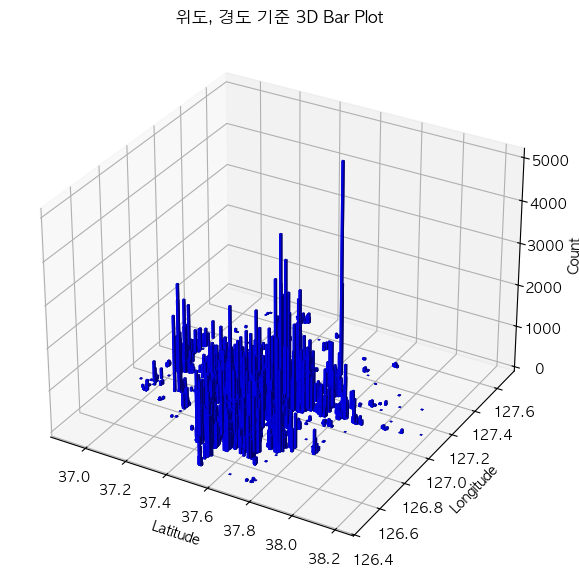

In [120]:
from mpl_toolkits.mplot3d import Axes3D

# 3D 그래프 그리기
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# x, y, z 데이터 설정 (latitude, longitude, count)
x = count_contract_df['latitude']
y = count_contract_df['longitude']
z = np.zeros(len(count_contract_df))  # 막대의 바닥 높이를 0으로 설정
dx = dy = 0.01  # 각 막대의 너비
dz = count_contract_df['count']  # 막대의 높이를 count로 설정

# 3D bar plot
ax.bar3d(x, y, z, dx, dy, dz, color='b', zsort='average')

# 축 설정
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Count')

# 그래프 출력
plt.title('위도, 경도 기준 3D Bar Plot')
plt.show()

### 갯수가 5108개가 카운트된 위도, 경도 확인

In [89]:
# 허용 오차를 두고 위도와 경도를 비교하여 데이터 필터링
specific_location_data = train_data[np.isclose(train_data['latitude'], 37.654629,) &
                                    np.isclose(train_data['longitude'], 127.340430,)]

# 결과 확인
print(specific_location_data)

         index   area_m2  contract_year_month  contract_day  contract_type  \
4097      4097   59.9632               201904             3              2   
4098      4098  147.0694               201904             3              2   
4099      4099   84.9727               201904             3              2   
4100      4100   59.9632               201904             3              2   
4101      4101   84.6054               201904             4              2   
...        ...       ...                  ...           ...            ...   
778937  778937   84.9947               202312            29              2   
778938  778938   59.9632               202312            29              2   
778939  778939   84.6054               202312            29              2   
778940  778940   84.6054               202312            29              2   
778941  778941   59.9632               202312            29              2   

        floor  built_year   latitude  longitude  age  deposit  

### 가장 거래 건수가 많은 아파트의 거래월 파악

In [33]:
specific_location_data['contract_year_month'].unique()

array([201904, 201905, 201906, 201907, 201908, 201909, 201910, 201911,
       201912, 202001, 202002, 202003, 202004, 202005, 202006, 202007,
       202008, 202009, 202010, 202011, 202012, 202101, 202102, 202103,
       202104, 202105, 202106, 202107, 202108, 202109, 202110, 202111,
       202112, 202201, 202202, 202203, 202204, 202205, 202206, 202207,
       202208, 202209, 202210, 202211, 202212, 202301, 202302, 202303,
       202304, 202305, 202306, 202307, 202308, 202309, 202310, 202311,
       202312])

In [90]:
specific_location_data["contract_year_month"] = pd.to_datetime(specific_location_data["contract_year_month"], format='%Y%m')

/var/folders/68/zvjwc4g973dgknpsjc6dy3g00000gn/T/ipykernel_40565/2204619142.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [91]:
deposit_and_interest_df["year_month"] = pd.to_datetime(deposit_and_interest_df["year_month"], format='%Y%m')

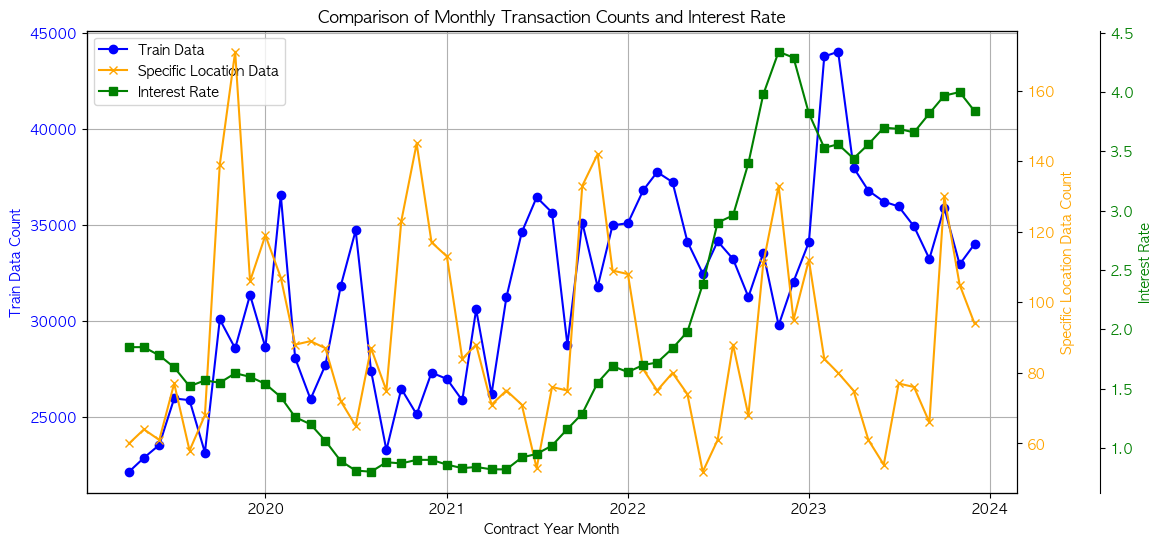

In [99]:
# train_data와 specific_location_data의 월별 거래량 계산
train_monthly_count = train_data['contract_year_month'].value_counts().sort_index()
specific_location_monthly_count = specific_location_data['contract_year_month'].value_counts().sort_index()

# 두 데이터를 비교하기 위한 DataFrame 생성
comparison_df = pd.DataFrame({
    'train_data': train_monthly_count,
    'specific_location_data': specific_location_monthly_count,
    'interest_rate': deposit_and_interest_df.set_index('year_month')['interest_rate']
})

# 그래프 그리기
fig, ax1 = plt.subplots(figsize=(12, 6))

# 첫 번째 y축 (전체 데이터의 거래량)
ax1.set_xlabel('Contract Year Month')
ax1.set_ylabel('Train Data Count', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# 두 번째 y축 (특정 지역의 거래량)
ax2 = ax1.twinx()
ax2.set_ylabel('Specific Location Data Count', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 세 번째 y축 (금리)
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # 세 번째 축을 조금 오른쪽으로 이동
ax3.set_ylabel('Interest Rate', color='green')
ax3.tick_params(axis='y', labelcolor='green')

# Plotting using for loop
for column, color, marker, ax in zip(['train_data', 'specific_location_data', 'interest_rate'], ['b', 'orange', 'green'], ['o', 'x', 's'], [ax1, ax2, ax3]):
    ax.plot(comparison_df.index, comparison_df[column], label=column.replace('_', ' ').title(), marker=marker, color=color)

# 제목과 범례
plt.title('Comparison of Monthly Transaction Counts and Interest Rate')
lines, labels = [], []
for ax in [ax1, ax2, ax3]:
    for line in ax.get_lines():
        lines.append(line)
        labels.append(line.get_label())
ax1.legend(lines, labels, loc='upper left')

# 첫 번째 y축의 그리드 설정
ax1.grid(True)

plt.show()


In [92]:
train_data["contract_year_month"] = pd.to_datetime(train_data["contract_year_month"], format='%Y%m')

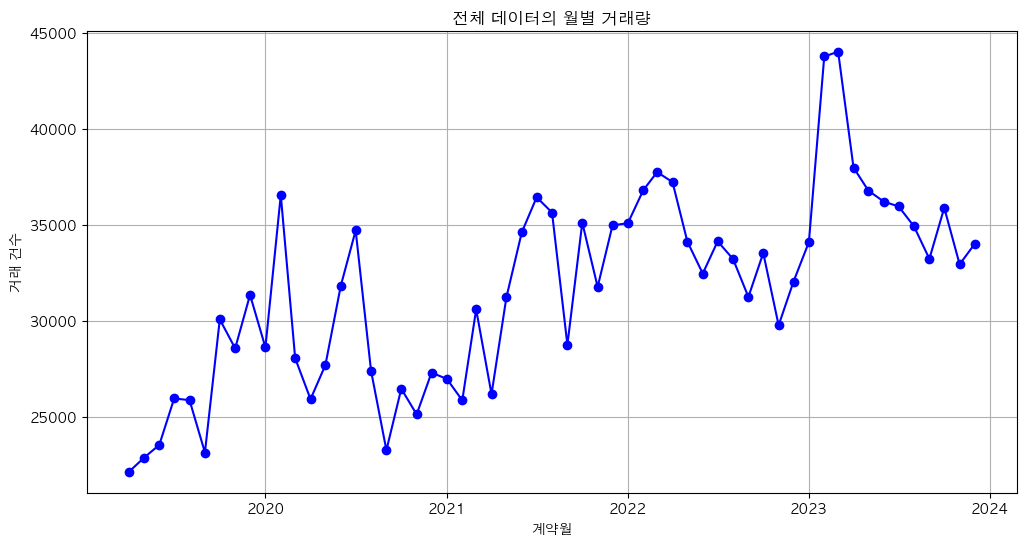

In [94]:
# contract_year_month별 갯수 계산
monthly_count = train_data['contract_year_month'].value_counts().sort_index()

# 선그래프 생성
plt.figure(figsize=(12, 6))
plt.plot(monthly_count.index, monthly_count.values, marker='o', linestyle='-', color='b')
plt.xlabel('계약월')
plt.ylabel('거래 건수')
plt.title('전체 데이터의 월별 거래량')
plt.grid(True)
plt.show()

In [72]:
import plotly.graph_objs as go
import pandas as pd
import numpy as np

# latitude와 longitude가 같은 행들의 개수 세기 및 내림차순 정렬
lat_long_counts = train_data.groupby(['latitude', 'longitude']).size().reset_index(name='count')

# 상위 10개의 데이터만 추출하여 3D 막대 그래프 그리기
top_10_lat_long_counts = lat_long_counts.head(10)

# x, y, z 데이터 설정 (latitude, longitude, count)
x = top_10_lat_long_counts['latitude']
y = top_10_lat_long_counts['longitude']
z = np.zeros(len(top_10_lat_long_counts))  # 막대의 바닥 높이를 0으로 설정
dz = top_10_lat_long_counts['count']  # 막대의 높이를 count로 설정

# 3D 막대 그래프 그리기
fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='lines',  # 선을 사용하여 막대를 시각화
    line=dict(color='blue', width=10),  # 막대 색과 너비 설정
    marker=dict(size=5),
)])

# 각 포인트에 막대 그래프처럼 세로로 선을 추가
for i in range(len(x)):
    fig.add_trace(go.Scatter3d(
        x=[x[i], x[i]],
        y=[y[i], y[i]],
        z=[0, dz[i]],  # z축 값을 0에서 count 값으로 변경하여 막대 높이를 표현
        mode='lines',
        line=dict(color='blue', width=5),
    ))

# 축 설정
fig.update_layout(
    title='상위 10개 위도, 경도 기준 3D Bar Plot',
    scene=dict(
        xaxis_title='Latitude',
        yaxis_title='Longitude',
        zaxis_title='Count'
    )
)

# 그래프 출력
fig.show()

In [99]:
deposit_and_interest_df["shift_interest_rate"] = deposit_and_interest_df["interest_rate"].shift(5)
corr_matrix = deposit_and_interest_df.corr()
corr_matrix

,year_month,monthly_transaction,interest_rate,avg_deposit,deposit_diff,interest_change,interest_binary,interest_category,shift_interest_rate
year_month,1.000000,0.706597,0.769114,0.691817,-0.046142,0.317162,0.390334,0.332171,0.699875
monthly_transaction,0.706597,1.000000,0.469879,0.466751,-0.167065,0.123793,0.298154,0.225683,0.490101
interest_rate,0.769114,0.469879,1.000000,0.206548,-0.049724,0.157002,0.186184,0.148875,0.857550
avg_deposit,0.691817,0.466751,0.206548,1.000000,0.131533,0.509336,0.456757,0.440311,-0.047910
deposit_diff,-0.046142,-0.167065,-0.049724,0.131533,1.000000,0.080816,0.044037,0.119036,0.080458
interest_change,0.317162,0.123793,0.157002,0.509336,0.080816,1.000000,0.761041,0.775893,-0.160947
interest_binary,0.390334,0.298154,0.186184,0.456757,0.044037,0.761041,1.000000,0.966821,-0.028625
interest_category,0.332171,0.225683,0.148875,0.440311,0.119036,0.775893,0.966821,1.000000,-0.067413
shift_interest_rate,0.699875,0.490101,0.857550,-0.047910,0.080458,-0.160947,-0.028625,-0.067413,1.000000


In [91]:
corr_matrix = deposit_and_interest_df.corr()
corr_matrix

,year_month,monthly_transaction,interest_rate,avg_deposit,deposit_diff,interest_change,interest_binary,interest_category,shift_interest_rate
year_month,1.000000,0.706597,0.769114,0.691817,-0.046142,0.317162,0.390334,0.332171,0.730381
monthly_transaction,0.706597,1.000000,0.469879,0.466751,-0.167065,0.123793,0.298154,0.225683,0.535467
interest_rate,0.769114,0.469879,1.000000,0.206548,-0.049724,0.157002,0.186184,0.148875,0.931184
avg_deposit,0.691817,0.466751,0.206548,1.000000,0.131533,0.509336,0.456757,0.440311,0.018707
deposit_diff,-0.046142,-0.167065,-0.049724,0.131533,1.000000,0.080816,0.044037,0.119036,-0.039730
interest_change,0.317162,0.123793,0.157002,0.509336,0.080816,1.000000,0.761041,0.775893,-0.107987
interest_binary,0.390334,0.298154,0.186184,0.456757,0.044037,0.761041,1.000000,0.966821,0.004238
interest_category,0.332171,0.225683,0.148875,0.440311,0.119036,0.775893,0.966821,1.000000,-0.033342
shift_interest_rate,0.730381,0.535467,0.931184,0.018707,-0.039730,-0.107987,0.004238,-0.033342,1.000000


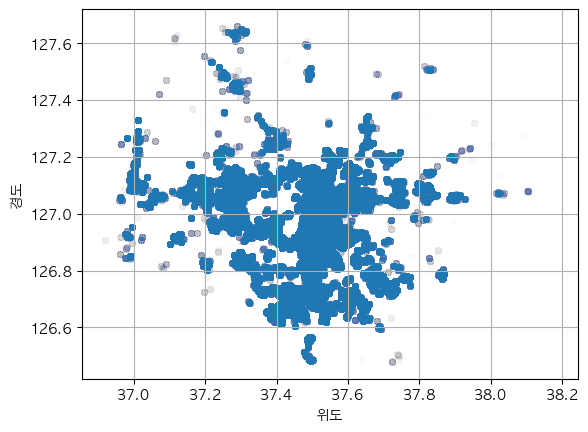

In [52]:
merge_data.plot(kind="scatter", x="latitude", y="longitude", grid=True, alpha=0.005)
plt.xlabel("위도")
plt.ylabel("경도")
plt.show()

/Users/jejunlee/miniconda3/envs/boostcamp/lib/python3.12/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


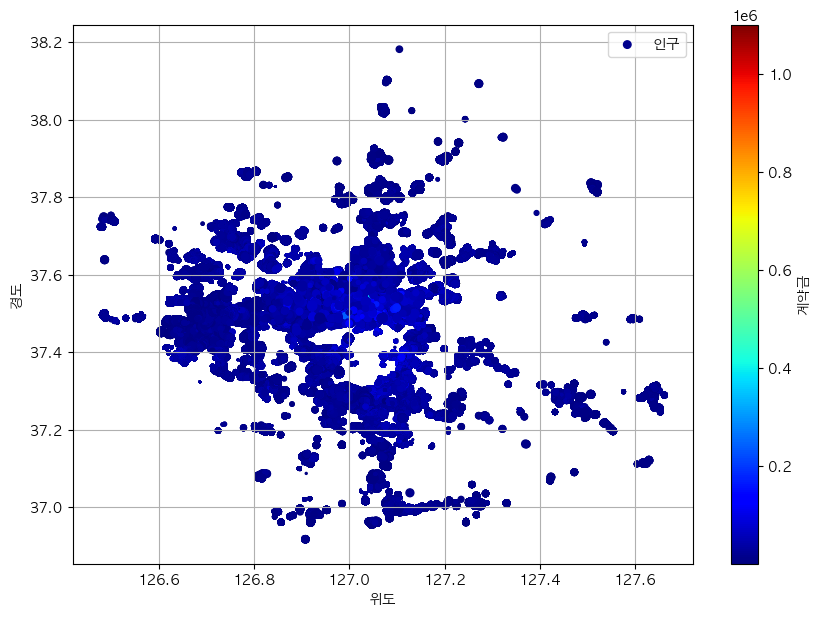

In [57]:
merge_data.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=merge_data["age"], label="인구",
             c="deposit", cmap="jet", colorbar=True,
             legend=True, figsize=(10, 7))
cax=plt.gcf().get_axes()[1]
cax.set_ylabel("계약금")
plt.xlabel("위도")
plt.ylabel("경도")
plt.show()

In [54]:
merge_data.columns

Index(['area_m2', 'contract_year_month', 'contract_day', 'contract_type',
       'floor', 'built_year', 'latitude', 'longitude', 'age', 'deposit',
       'interest_rate'],
      dtype='object')